[ 0.52095422  1.85554492  8.5598      0.18116821  0.08043457  1.524
  0.         -9.81        0.        ]
[ 0.52269419  1.85327849  8.55980304 -0.19403157  0.56362833  1.52338391
 -1.25622899 -9.16817277 -0.01864541]
18
Time for kalman filter is 0.17399859428405762 seconds
[array([-0.01481538,  0.00380478,  0.00106823]), array([-2.72051946e-02,  4.32466940e-05,  2.60808629e-03]), array([ 0.02316679, -0.02953387,  0.00473724]), array([ 0.02396802, -0.02001129,  0.00745568]), array([ 0.01576848, -0.06512815,  0.01076343]), array([ 0.02789109, -0.12673479,  0.01466047]), array([ 0.09114863, -0.11706949,  0.01914682]), array([ 0.09189726, -0.12475493,  0.02422245]), array([ 0.08457086, -0.10589829,  0.02988739]), array([ 0.08619714, -0.13988763,  0.03614163])]
10


Text(0.5, 0.5, 'Width (meters)')

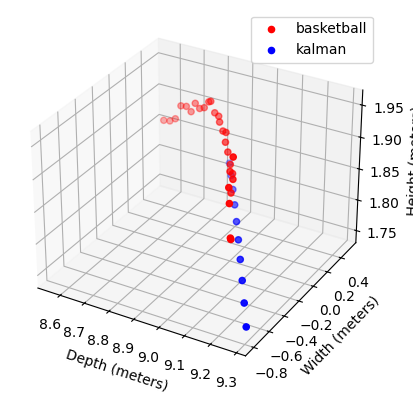

In [52]:

import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import math
import matplotlib.animation as animation
from sympy import Symbol, solve
from math import*
from pykalman import KalmanFilter

projectile_df = pd.read_csv("position_data1712872396.192517.csv")        
projectile_df = projectile_df.dropna()
basketball_x = projectile_df['x'].values
basketball_x = basketball_x[10:]
basketball_x = basketball_x *25.4 / 1000
basketball_y = projectile_df['y'].values
basketball_y = basketball_y *25.4 / 1000
basketball_y = basketball_y[10:]
basketball_z = projectile_df['z'].values
basketball_z =  basketball_z[10:]
basketball_z = basketball_z *25.4/1000


framerate = 60
initial_distance = basketball_y[1]-basketball_y[0]
time1 = time.time()
initial_velocity = (basketball_y[1]-basketball_y[0]) * framerate 
initial_x_velocity = (basketball_x[1]-basketball_x[0]) * framerate 
initial_z_velocity = (basketball_z[1]-basketball_z[0]) * framerate 
dT = 1 / framerate
g = 9.81
#initial_state = np.asarray([basketball_x[0],basketball_y[0],basketball_z[0],0,0,0,0,0,0])
initial_state = np.asarray([basketball_x[0],basketball_y[0],basketball_z[0],initial_x_velocity,initial_velocity,initial_z_velocity,0,-1*g,0])
print(initial_state)
transition_matrix = np.asarray(
    [
        [1., 0., 0., dT, 0., 0., 0., 0., 0.], # x pos
        [0., 1., 0., 0., dT, 0., 0., 0., 0.], # y pos
        [0., 0., 1., 0., 0., dT, 0., 0., 0.], # z pos
        [0., 0., 0., 1., 0., 0., dT, 0., 0.], # x velocity
        [0., 0., 0., 0., 1., 0., 0., dT, 0.], # y velocity
        [0., 0., 0., 0., 0., 1., 0., 0., dT], # z velocity
        [0., 0., 0., 0., 0., 0., 1., 0., 0.], # x accel
        [0., 0., 0., 0., 0., 0., 0., 1., 0.], # y accel
        [0., 0., 0., 0., 0., 0., 0., 0., 1.] # z accel
    ]
)
observation_matrix = np.asarray(
    [
        [1, 0, 0, 0, 0, 0,0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0]
    ]
)





kf1 = KalmanFilter(transition_matrices = transition_matrix,
                observation_matrices = observation_matrix,
                initial_state_mean = initial_state)
measurements = []

for values in zip(basketball_x,basketball_y,basketball_z):
    measurements.append(values)

shrink_factor =1.5

#measurements = measurements[0::int(len(measurements)/60)]

kf1 = kf1.em(measurements[:int(len(measurements)//shrink_factor)], n_iter=20)
print(kf1.initial_state_mean)
#sys.exit(1)
print(len(measurements[:int(len(measurements)//shrink_factor)]))
(smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements[:int(len(measurements)//shrink_factor)])
next_mean = smoothed_state_means[-1]
next_covar = smoothed_state_covariances[-1]
second_half = measurements[int(len(measurements)//shrink_factor):]
predicted_error = []
predicted_state_means = []
predicated_state_covariances = []
pitch = []
yaw = []
for measure in second_half:
    next_mean, next_covar = kf1.filter_update(next_mean,next_covar)
    predicted_state_means.append(next_mean)
    predicated_state_covariances.append(next_covar)
    error = next_mean[0:3] - measure
    predicted_error.append(error)
    yaw.append(math.degrees(np.arctan(next_mean[2]/next_mean[0])))
    pitch.append(math.degrees(np.arctan(next_mean[1]/(np.sqrt(np.power(next_mean[0],2) + np.power(next_mean[2],2))))))
time2 = time.time()
predicted_state_means = np.array(predicted_state_means)
print("Time for kalman filter is " + str(time2-time1) + " seconds")
#print(predicted_error)
print(predicted_error)
#print(yaw)
#print(pitch)
print(len(predicted_state_means))
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(basketball_z, basketball_x, basketball_y, c = 'red', label = "basketball")
ax.scatter(predicted_state_means[:,2], predicted_state_means[:,0], predicted_state_means[:,1], c = 'blue', label="kalman")
ax.legend()
ax.set_xlabel("Depth (meters)")
ax.set_zlabel("Height (meters)")
ax.set_ylabel("Width (meters)")